In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

raw_data = pd.read_csv('heart_attack_prediction_dataset.csv')




In [2]:
print(raw_data.info())
raw_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Age                              8763 non-null   int64  
 2   Sex                              8763 non-null   object 
 3   Cholesterol                      8763 non-null   int64  
 4   Blood Pressure                   8763 non-null   object 
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null   float64
 12  Diet                

Patient ID  Age     Sex  Cholesterol Blood Pressure  Heart Rate  \
0       BMW7812   67    Male          208         158/88          72   
1       CZE1114   21    Male          389         165/93          98   
2       BNI9906   21  Female          324         174/99          72   
3       JLN3497   84    Male          383        163/100          73   
4       GFO8847   66    Male          318          91/88          93   
...         ...  ...     ...          ...            ...         ...   
8758    MSV9918   60    Male          121          94/76          61   
8759    QSV6764   28  Female          120        157/102          73   
8760    XKA5925   47    Male          250         161/75         105   
8761    EPE6801   36    Male          178         119/67          60   
8762    ZWN9666   25  Female          356         138/67          75   

      Diabetes  Family History  Smoking  Obesity  ...  \
0            0               0        1        0  ...   
1            1               1        1        1  ...   
2            1               0        0        0  ...   
3            1               1        1        0  ...   
4            1               1        1        1  ...   
...        ...             ...      ...      ...  ...   
8758         1               1        1        0  ...   
8759         1               0        0        1  ...   
8760         0               1        1        1  ...   
8761         1               0        1        0  ...   
8762         1               1        0        0  ...   

      Sedentary Hours Per Day  Income        BMI  Triglycerides  \
0                    6.615001  261404  31.251233            286   
1                    4.963459  285768  27.194973            235   
2                    9.463426  235282  28.176571            587   
3                    7.648981  125640  36.464704            378   
4                    1.514821  160555  21.809144            231   
...                       ...     ...        ...            ...   
8758                10.806373  235420  19.655895             67   
8759                 3.833038  217881  23.993866            617   
8760                 2.375214   36998  35.406146            527   
8761                 0.029104  209943  27.294020            114   
8762                 9.005234  247338  32.914151            180   

      Physical Activity Days Per Week  Sleep Hours Per Day         Country  \
0                                   0                    6       Argentina   
1                                   1                    7          Canada   
2                                   4                    4          France   
3                                   3                    4          Canada   
4                                   1                    5        Thailand   
...                               ...                  ...             ...   
8758                                7                    7        Thailand   
8759                                4                    9          Canada   
8760                                4                    4          Brazil   
8761                                2                    8          Brazil   
8762                                7                    4  United Kingdom   

          Continent           Hemisphere  Heart Attack Risk  
0     South America  Southern Hemisphere                  0  
1     North America  Northern Hemisphere                  0  
2            Europe  Northern Hemisphere                  0  
3     North America  Northern Hemisphere                  0  
4              Asia  Northern Hemisphere                  0  
...             ...                  ...                ...  
8758           Asia  Northern Hemisphere                  0  
8759  North America  Northern Hemisphere                  0  
8760  South America  Southern Hemisphere                  1  
8761  South America  Southern Hemisphere                  0  
8762         Europe  Northern H

In [3]:
# Let's normalize some values.
scaler = StandardScaler()
raw_data[['Age', 'Cholesterol']] = scaler.fit_transform(raw_data[['Age', 'Cholesterol']])

##Get rid of outliers (heart rate for now)
Q1 = raw_data['Heart Rate'].quantile(0.25)
Q3 = raw_data['Heart Rate'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

raw_data = raw_data[(raw_data['Heart Rate'] >= lower_bound) & (raw_data['Heart Rate'] <= upper_bound)]

# FEATURE SELECTION

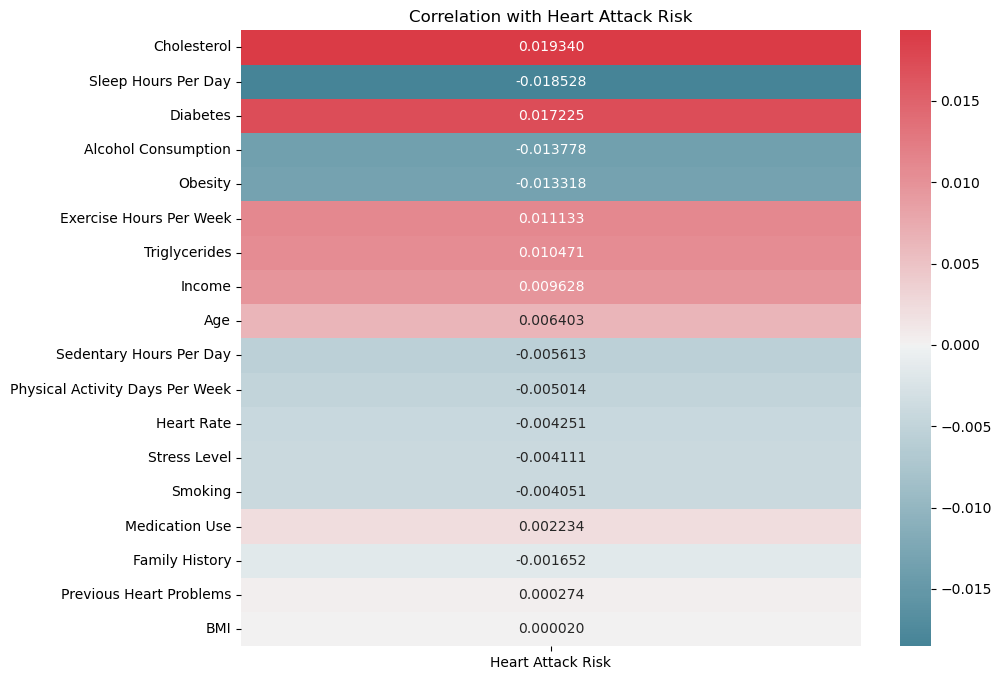

In [4]:
# Let's create our correlation matrix
numeric_columns = raw_data.select_dtypes(include=['number'])

correlation_matrix = numeric_columns.corr()

# Calculate correlations between all variables and 'Heart Attack Risk'
corr_to_hrisk = correlation_matrix['Heart Attack Risk']

# Sort by magnitude(we care more about impact)
corr_to_hrisk = corr_to_hrisk.drop('Heart Attack Risk')  # Remove the correlation with itself
corr_to_hrisk = corr_to_hrisk.abs().sort_values(ascending=False)

# Create our color map for both positive and negative
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(10, 8))

# Let's make our heatmap (sorted by absolute value)
sns.heatmap(
    correlation_matrix.loc[corr_to_hrisk.index, ['Heart Attack Risk']],
    annot=True,
    cmap=cmap,
    fmt=".6f",
    center=0, 
)

plt.title('Correlation with Heart Attack Risk')
plt.show()

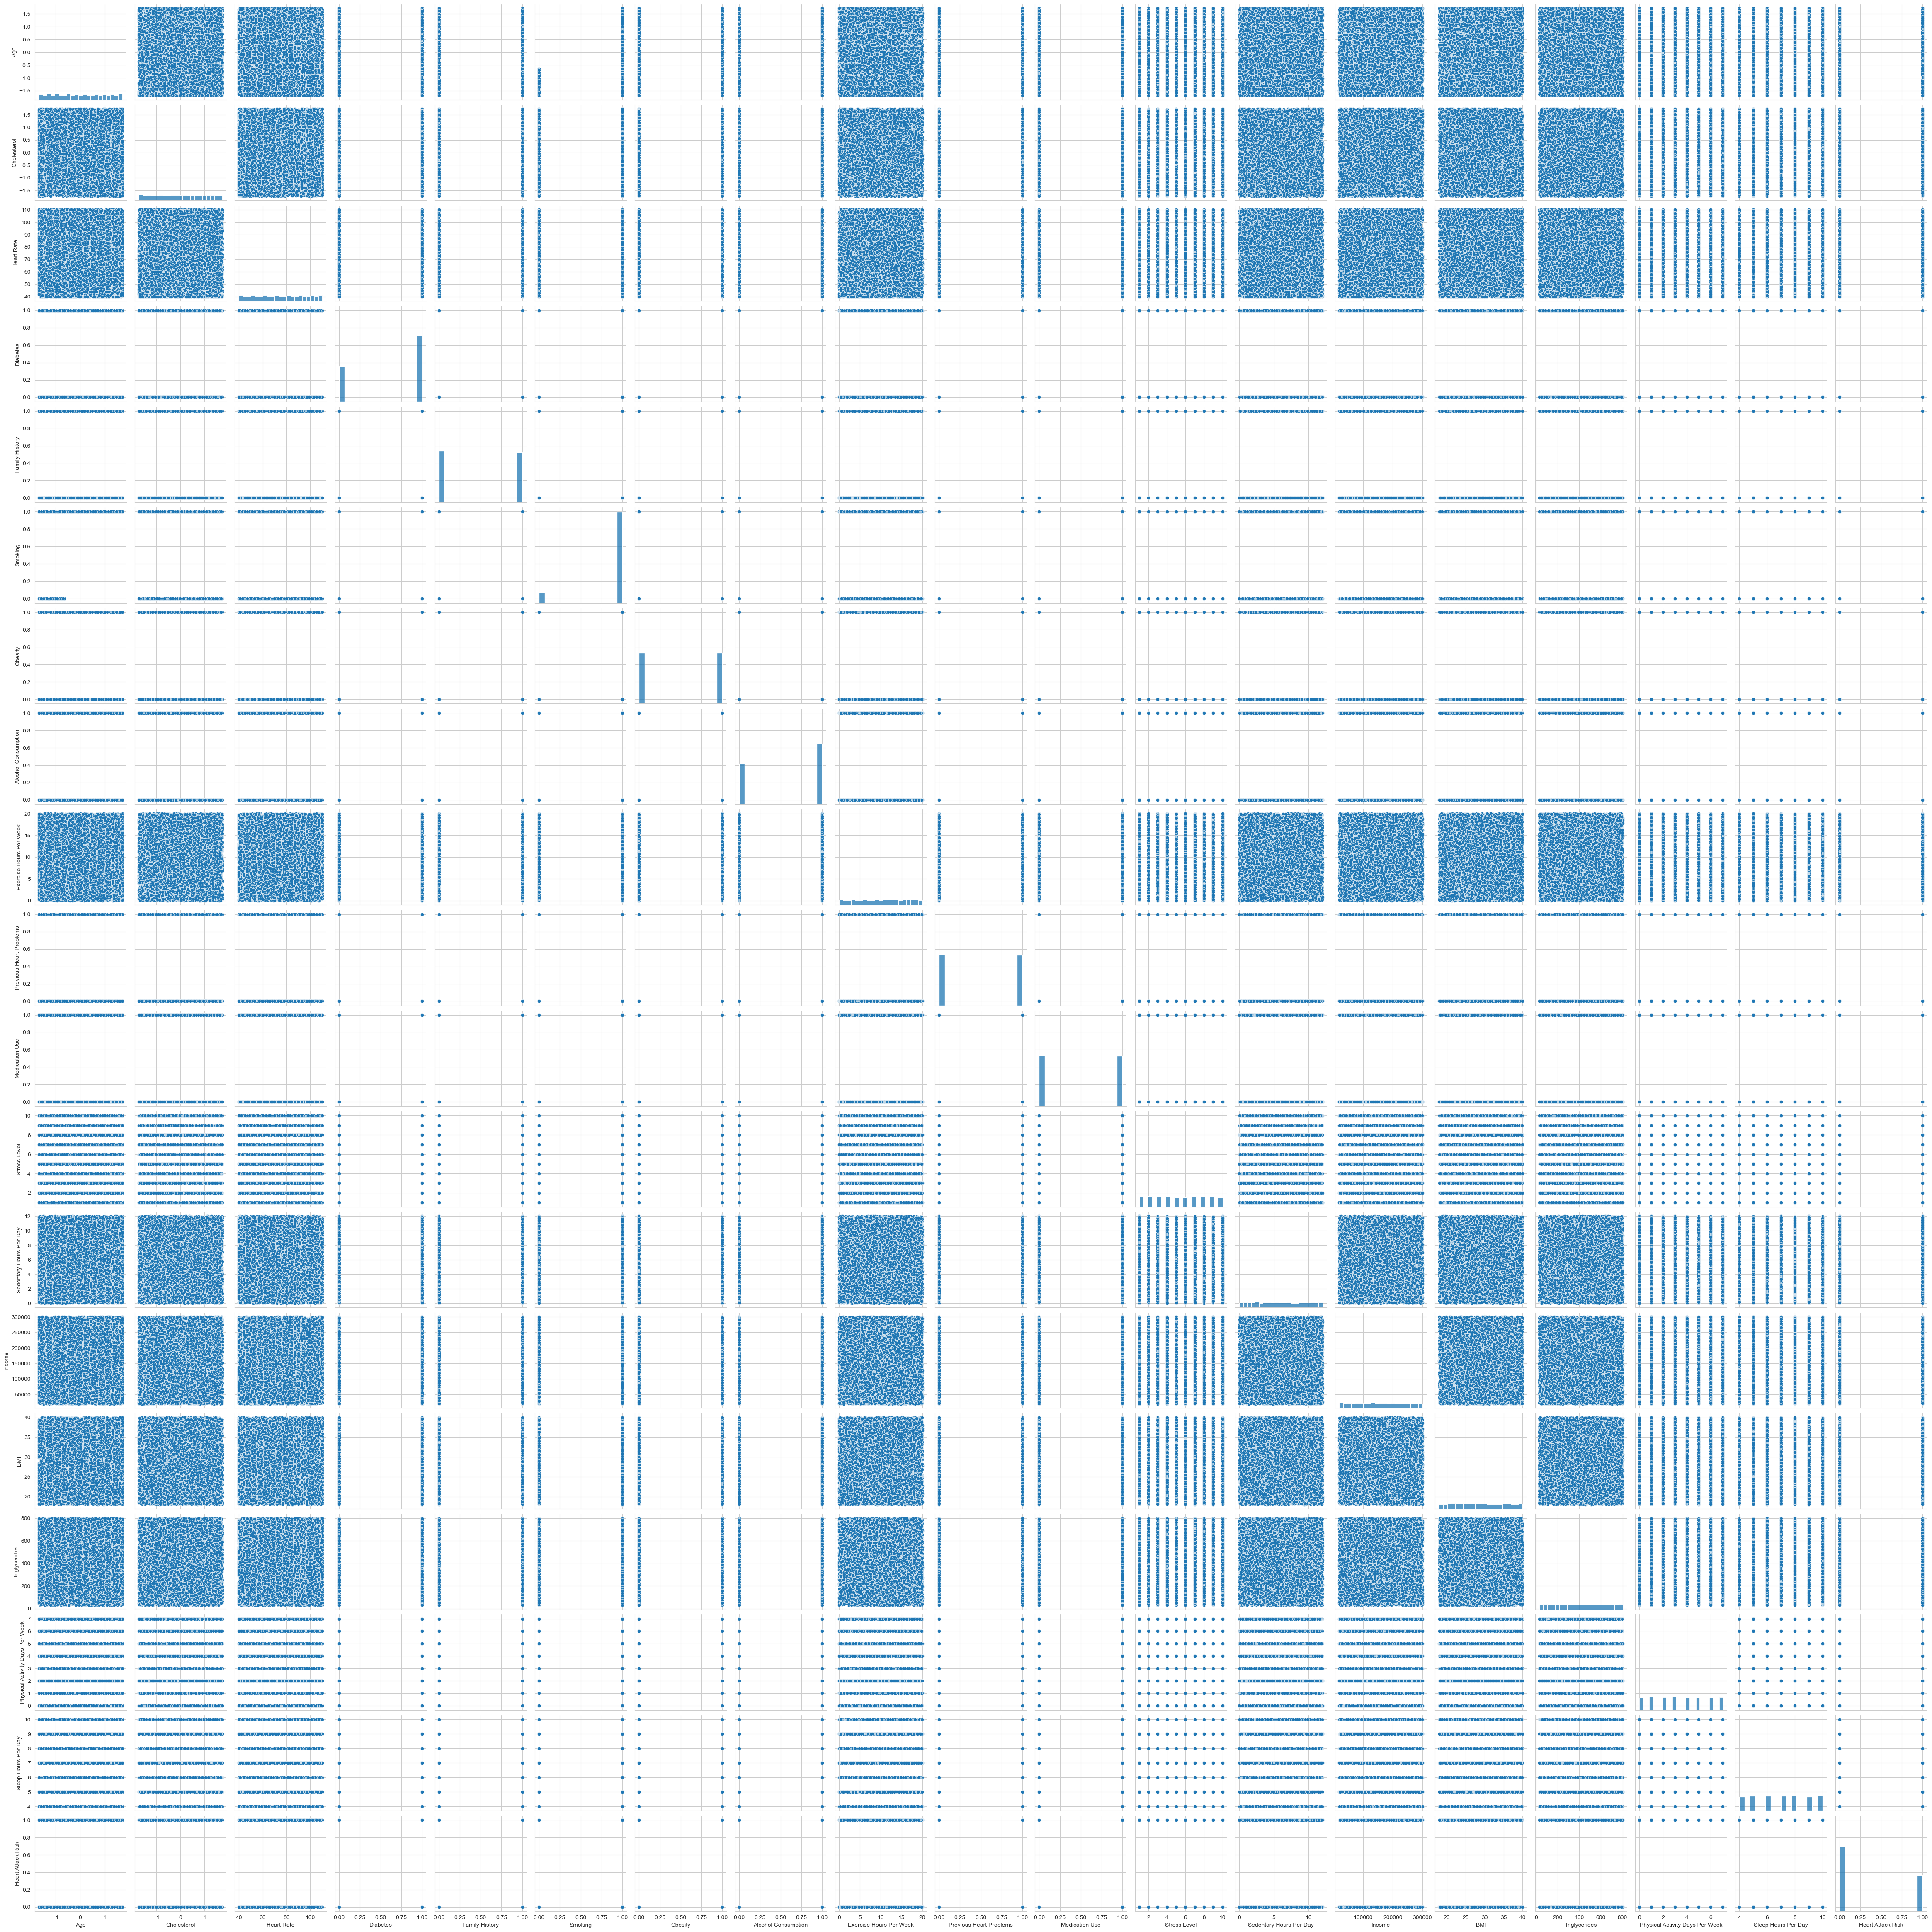

In [5]:
#let's create a pairplot of the data
numeric_columns
sns.set_style("whitegrid");
sns.pairplot(numeric_columns);
plt.show()

# LOGISTIC REGRESSION

In [6]:
# Split bp cause it doesnt encode well; has 2 values
raw_data[['Systolic', 'Diastolic']] = raw_data['Blood Pressure'].str.split('/', expand=True).astype(int)

# Drop the original "Blood Pressure" column
raw_data = raw_data.drop(columns=['Blood Pressure'])

# Let's encode the categories
label_encoder = LabelEncoder()
categorical_cols = ['Sex', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Country', 'Continent', 'Hemisphere']
for col in categorical_cols:
    raw_data[col] = label_encoder.fit_transform(raw_data[col])

# set x and y
X = raw_data.drop(columns=['Patient ID', 'Heart Attack Risk'])
y = raw_data['Heart Attack Risk']

# make the test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale and normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# find predictions
y_pred = model.predict(X_test)

# evaluate model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

# control precision and f1 score (zero division=1)
report = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(report)


Accuracy: 0.6417569880205363
Confusion Matrix:
[[1125    0]
 [ 628    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       1.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.82      0.50      0.39      1753
weighted avg       0.77      0.64      0.50      1753



# LOGISTIC REGRESSION BASED ON RECURSIVE FEATURE ELIMINATION (RFE)

In [8]:
pip install yellowbrick seaborn


Results after Feature Selection (RFE):
Accuracy: 0.6417569880205363
Confusion Matrix:
[[1125    0]
 [ 628    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       1.00      0.00      0.00       628

    accuracy                           0.64      1753
   macro avg       0.82      0.50      0.39      1753
weighted avg       0.77      0.64      0.50      1753



C:\Users\Sohail_Comp\anaconda3\lib\site-packages\yellowbrick\model_selection\importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


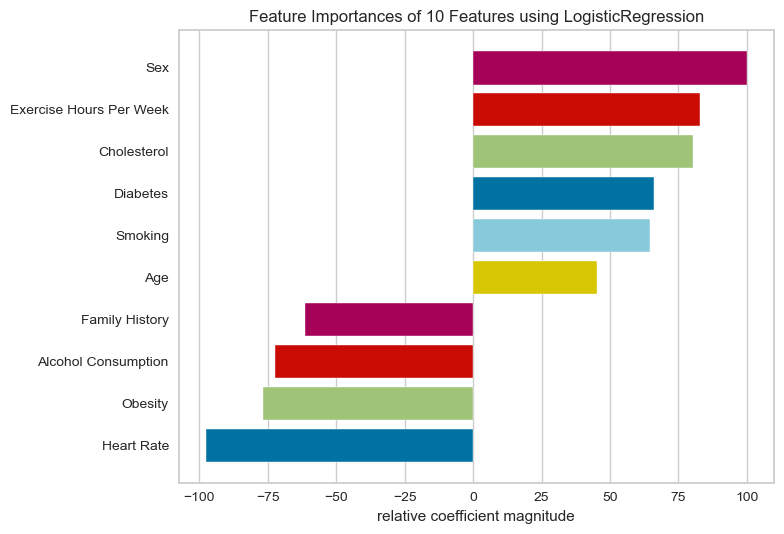

<AxesSubplot:title={'center':'Feature Importances of 10 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.model_selection import FeatureImportances

# Let's normalize some values.
scaler = StandardScaler()
raw_data[['Age', 'Cholesterol']] = scaler.fit_transform(raw_data[['Age', 'Cholesterol']])

##Get rid of outliers (heart rate for now)
Q1 = raw_data['Heart Rate'].quantile(0.25)
Q3 = raw_data['Heart Rate'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

raw_data = raw_data[(raw_data['Heart Rate'] >= lower_bound) & (raw_data['Heart Rate'] <= upper_bound)]

# Apply Recursive Feature Elimination (RFE)
num_features_to_select = 10  # You can adjust this number
rfe = RFE(LogisticRegression(max_iter=1000), n_features_to_select=num_features_to_select)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Train logistic regression model with selected features
model_rfe = LogisticRegression(max_iter=1000)
model_rfe.fit(X_train_rfe, y_train)

# Find predictions using the model with selected features
y_pred_rfe = model_rfe.predict(X_test_rfe)

# Evaluate model with selected features
accuracy_rfe = accuracy_score(y_test, y_pred_rfe)
confusion_rfe = confusion_matrix(y_test, y_pred_rfe)
report_rfe = classification_report(y_test, y_pred_rfe, zero_division=1)

print("Results after Feature Selection (RFE):")
print(f"Accuracy: {accuracy_rfe}")
print("Confusion Matrix:")
print(confusion_rfe)
print("Classification Report:")
print(report_rfe)

# Visualize Feature Importances
visualizer = FeatureImportances(model_rfe, labels=X.columns)
visualizer.fit(X_train_rfe, y_train)
visualizer.show()


# FEED_FORWARD NEURAL NETWORK

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2 as l2_keras
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load data
raw_data = pd.read_csv('import pandas as pd.csv')
raw_data[['Systolic', 'Diastolic']] = raw_data['Blood Pressure'].str.split('/', expand=True).astype(int)
raw_data = raw_data.drop(columns=['Blood Pressure'])

# Encode categorical columns
label_encoder = LabelEncoder()
categorical_cols = ['Sex', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Country', 'Continent', 'Hemisphere']
for col in categorical_cols:
    raw_data[col] = label_encoder.fit_transform(raw_data[col])

# Set X and y
X = raw_data.drop(columns=['Patient ID', 'Heart Attack Risk'])
y = raw_data['Heart Attack Risk']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the model function
def create_model(learning_rate=0.01, dropout_rate=0.5, l2_penalty=0.01):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2_keras(l2_penalty)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2_keras(l2_penalty)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Grid search parameters
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'dropout_rate': [0.3, 0.5, 0.7],
    'l2_penalty': [0.001, 0.01, 0.1]
}

# Manual grid search
results = []

for lr in param_grid['learning_rate']:
    for dr in param_grid['dropout_rate']:
        for l2_val in param_grid['l2_penalty']:
            model = create_model(learning_rate=lr, dropout_rate=dr, l2_penalty=l2_val)
            history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=0)
            y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary predictions
            test_accuracy = accuracy_score(y_test, y_pred)
            test_loss = model.evaluate(X_test, y_test, verbose=0)[0]  # Extract the test loss
            mse = mean_squared_error(y_test, y_pred)  # Calculate Mean Squared Error
            results.append({
                'learning_rate': lr,
                'dropout_rate': dr,
                'l2_penalty': l2_val,
                'history': history,
                'test_accuracy': test_accuracy,
                'test_loss': test_loss,
                'mse': mse
            })

# Find the best model
best_result = max(results, key=lambda x: x['test_accuracy'])

# Print the best parameters and metrics
print("Best Parameters: ", best_result)
print(f'Test Accuracy: {best_result["test_accuracy"]}')
print(f'Test Loss: {best_result["test_loss"]}')
print(f'Mean Squared Error: {best_result["mse"]}')



FileNotFoundError: [Errno 2] No such file or directory: 'import pandas as pd.csv'

In [ ]:
plt.plot(best_result['history'].history['accuracy'], label='Training Accuracy')
plt.plot(best_result['history'].history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# RANDOM FOREST CLASSIFIER



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.metrics import accuracy_score

raw_data = pd.read_csv('import pandas as pd.csv')
raw_data[['Systolic', 'Diastolic']] = raw_data['Blood Pressure'].str.split('/', expand=True).astype(int)
raw_data = raw_data.drop(columns=['Blood Pressure'])

label_encoder = LabelEncoder()
categorical_cols = ['Sex', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Country', 'Continent', 'Hemisphere']

for col in categorical_cols:
    raw_data[col] = label_encoder.fit_transform(raw_data[col])



X = raw_data.drop(columns=['Patient ID', 'Heart Attack Risk'])
y = raw_data['Heart Attack Risk']

data_train, data_test, class_train, class_test = train_test_split(X, y, test_size=0.1)

# start with base accuracy/model
best_accuracy = 0
best_model = None

# make 10 random trees and save best
for _ in range(10):  # lets do 10
    clf = RandomForestClassifier(n_estimators=50).fit(data_train, class_train)
    pred = clf.predict(data_test)
    current_accuracy = accuracy_score(class_test, pred)

    # assign best model based on test accuracy
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_model = clf

# Print the accuracy of the best model
print("Best Accuracy : ", best_accuracy)


from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score

pred = best_model.predict(data_test)

print("Accuracy : ", accuracy_score(class_test, pred))
print("Mean Square Error : ", mean_squared_error(class_test, pred))

print(pred[:5])

print("Confusion Matrix for each label : ")
print(multilabel_confusion_matrix(class_test, pred))

print("Classification Report : ")
print(classification_report(class_test, pred))

In [ ]:
from sklearn.metrics import plot_confusion_matrix

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
conf_matrix = confusion_matrix(class_test, pred)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualize Feature Importance
feature_importance = best_model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': data_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top N most important features
top_n = 10  # You can adjust this value based on the number of features you want to visualize
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette='viridis')
plt.title('Top {} Most Important Features'.format(top_n))
plt.show()
